# Online Retail Data Clustering

This is a simple clustering analysis of the Online Retail II dataset. 

Data taken from https://archive.ics.uci.edu/dataset/352/online+retail+ii


## Import modules and set display options

In [176]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:20.3f}'.format

## Data Loading and Initial Exploration

First, we load the Online Retail II dataset and examine its structure. This dataset contains transaction records from an online retail store, including information about:
- Invoice details
- Products (StockCode, Description, Price)
- Customer information
- Transaction dates and quantities

In [177]:
# Loading the data
df = pd.read_excel('./data/online_retail_II.xlsx', sheet_name=0)

# Display the first 5 rows of the dataframe
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom


In [178]:
# Display basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [179]:
# Display summary statistics of the dataframe for numerical columns
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000,525461,525461.000,417534.000
mean,10.338,2010-06-28 11:37:36.845017856,4.689,15360.645
min,-9600.000,2009-12-01 07:45:00,-53594.360,12346.000
25%,1.000,2010-03-21 12:20:00,1.250,13983.000
50%,3.000,2010-07-06 09:51:00,2.100,15311.000
75%,10.000,2010-10-15 12:45:00,4.210,16799.000
max,19152.000,2010-12-09 20:01:00,25111.090,18287.000
std,107.424,NaN,146.127,1680.811


In [180]:
# Display the summary statistics of the dataframe for categorical columns
df.describe(include=['object'])

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [181]:
# Check for missing values
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

### Data Quality Check

The dataset contains:
- 525,461 transactions
- 8 columns of information 
- Some missing values in Description (2,928) and Customer ID (107,927)

Key columns for our analysis:
- Customer ID: To identify unique customers
- InvoiceDate: For recency analysis
- Price & Quantity: For monetary value calculation
- Invoice: For frequency analysis

In [182]:
# Investigate the missing customer IDs
df[df['Customer ID'].isnull()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.000,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.000,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.000,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.000,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.550,NaN,United Kingdom


In [183]:
# Investigate negative quantities
df[df['Quantity'] < 0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.950,16321.000,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.650,16321.000,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.250,16321.000,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.100,16321.000,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.950,16321.000,Australia


In [184]:
# Set invoice to string
df['Invoice'] = df['Invoice'].astype(str)

# Validate invoice numbers (C, for cancellations, should be the only letter being used)
df[df['Invoice'].str.match('^\\d{6}$') == False].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.950,16321.000,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.650,16321.000,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.250,16321.000,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.100,16321.000,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.950,16321.000,Australia


In [185]:
# Replace digits with empty string to see what other letters are in the invoice numbers
df['Invoice'].str.replace('\\d', '', regex=True).unique()

array(['', 'C', 'A'], dtype=object)

In [186]:
# Checking the invoices that start with A
df[df['Invoice'].str.startswith('A')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.360,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.790,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.870,NaN,United Kingdom


In [187]:
# Set stock code to string
df['StockCode'] = df['StockCode'].astype(str)

# Check for stock codes that are not 5 digits recurring or 5 digits with a letter at the end
df[(df['StockCode'].str.match('^\\d{5}[a-zA-Z]*$') == False)]['StockCode'].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

Going through the data it seems most of these stock codes should be excluded as they are not products, with the exception of 'PADS'.

## Data Cleaning

In [188]:
# Make a copy of the dataframe to work with
df_cleaned = df.copy()

In [189]:
# Set invoice to string
df_cleaned['Invoice'] = df_cleaned['Invoice'].astype(str)

# Set stock code to string
df_cleaned['StockCode'] = df_cleaned['StockCode'].astype(str)

In [190]:
# Create a mask to identify rows to exclude for invoice numbers
mask = (
    df_cleaned['Invoice'].str.match('^\\d{6}$') == True
)

# Apply the mask to the dataframe
df_cleaned = df_cleaned[mask]

In [191]:
# Create a mask to identify rows to exclude for stock codes
mask = (
    (df_cleaned['StockCode'].str.match('^\\d{5}[a-zA-Z]*$') == True) |
    (df_cleaned['StockCode'] == 'PADS')
)

# Apply the mask to the dataframe
df_cleaned = df_cleaned[mask]

In [192]:
# Drop rows with null customer IDs
df_cleaned = df_cleaned.dropna(subset=['Customer ID'])

# Drop rows with 0 price
df_cleaned = df_cleaned[df_cleaned['Price'] > 0]

In [193]:
# Display the summary statistics of the cleaned dataframe
df_cleaned.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406309.000,406309,406309.000,406309.000
mean,13.618,2010-07-01 10:14:25.869572352,2.992,15373.722
min,1.000,2009-12-01 07:45:00,0.001,12346.000
25%,2.000,2010-03-26 14:01:00,1.250,14006.000
50%,5.000,2010-07-09 15:48:00,1.950,15326.000
75%,12.000,2010-10-14 17:09:00,3.750,16814.000
max,19152.000,2010-12-09 20:01:00,295.000,18287.000
std,96.999,NaN,4.286,1677.329


In [194]:
# Display the percentage of the original data that remains
print(f'Dataframe has been cleaned. {len(df_cleaned)/len(df) * 100:.2f}% of the original data remains.')

Dataframe has been cleaned. 77.32% of the original data remains.


## Feature Engineering

In [195]:
# Create a new column for the total sales per line
df_cleaned['SalesLineTotal'] = df_cleaned['Quantity'] * df_cleaned['Price']

# Display the first 5 rows of the dataframe
df_cleaned.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom,83.400
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom,100.800
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom,30.000


In [196]:
# Aggregate the data by customer ID and calculate values
df_aggregated = df_cleaned.groupby(by=['Customer ID'], as_index=False).agg(
    MonetaryValue=('SalesLineTotal', 'sum'),
    Frequency=('Invoice', 'nunique'),
    LastInvoiceDate=('InvoiceDate', 'max')
)

# View the first 5 rows of the aggregated dataframe
df_aggregated.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.000,169.360,2,2010-06-28 13:53:00
1,12347.000,1323.320,2,2010-12-07 14:57:00
2,12348.000,221.160,1,2010-09-27 14:59:00
3,12349.000,2221.140,2,2010-10-28 08:23:00
4,12351.000,300.930,1,2010-11-29 15:23:00


In [197]:
# Get the maximum invoice date
max_invoice_date = df_aggregated['LastInvoiceDate'].max()

# Calculate the recency of a customer's last invoice date in days
df_aggregated['RecencyInDays'] = (max_invoice_date - df_aggregated['LastInvoiceDate']).dt.days

# View the first 5 rows of the dataframe
df_aggregated.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyInDays
0,12346.000,169.360,2,2010-06-28 13:53:00,164
1,12347.000,1323.320,2,2010-12-07 14:57:00,2
2,12348.000,221.160,1,2010-09-27 14:59:00,73
3,12349.000,2221.140,2,2010-10-28 08:23:00,42
4,12351.000,300.930,1,2010-11-29 15:23:00,10


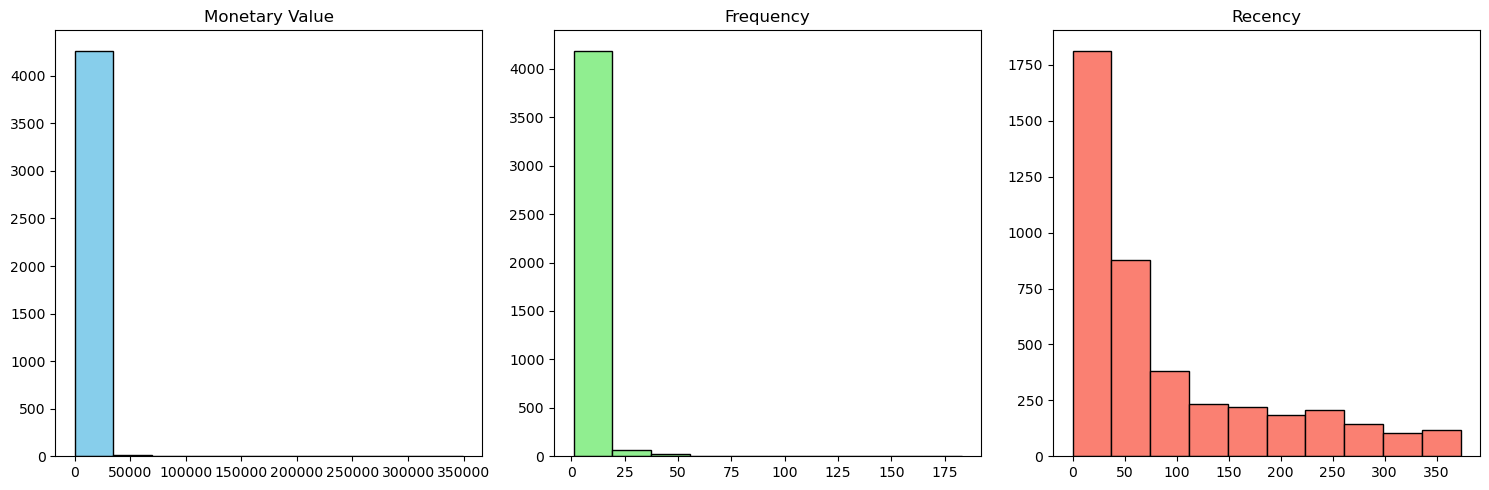

In [198]:
# Plot the distribution of all features to get a sense of the data
plt.figure(figsize=(15, 5))

# Monetary Value
plt.subplot(1, 3, 1)
plt.hist(df_aggregated['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value')

# Frequency
plt.subplot(1, 3, 2)
plt.hist(df_aggregated['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency')

# Recency
plt.subplot(1, 3, 3)
plt.hist(df_aggregated['RecencyInDays'], bins=10, color='salmon', edgecolor='black')
plt.title('Recency')

plt.tight_layout()
plt.show()

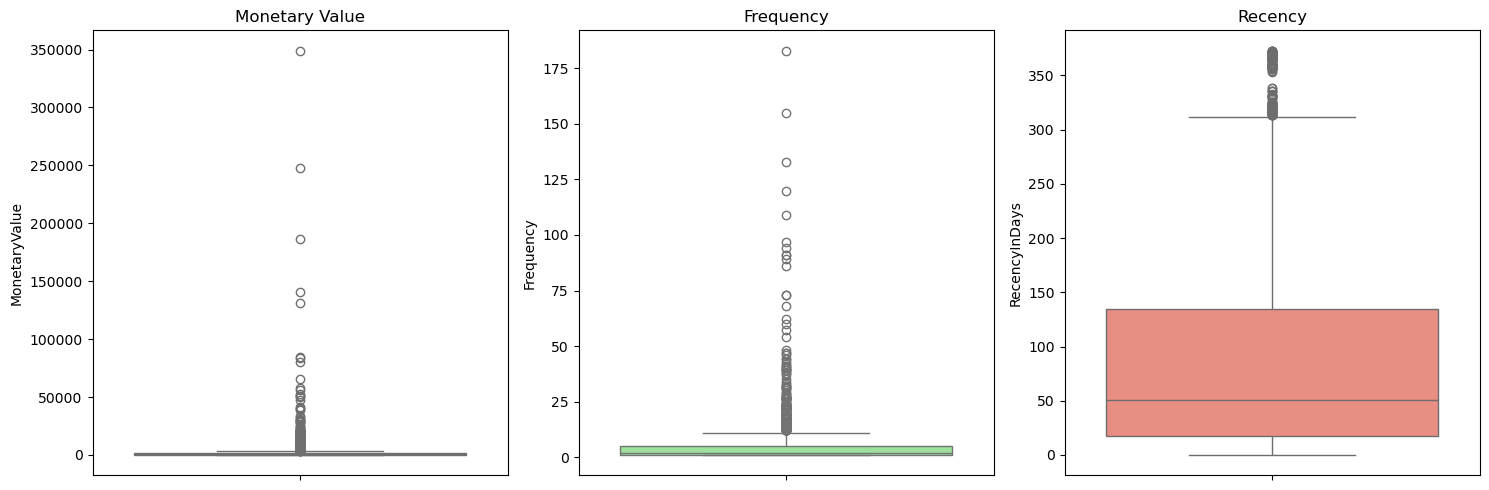

In [199]:
# Plot a boxplot to check for outliers
plt.figure(figsize=(15, 5))

# Monetary Value
plt.subplot(1, 3, 1)
sns.boxplot(df_aggregated['MonetaryValue'], color='skyblue')
plt.title('Monetary Value')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(df_aggregated['Frequency'], color='lightgreen')
plt.title('Frequency')

# Recency
plt.subplot(1, 3, 3)
sns.boxplot(df_aggregated['RecencyInDays'], color='salmon')
plt.title('Recency')

plt.tight_layout()
plt.show()

We want to separate the outliers from the rest of the data, as it is skewing the data.

In [200]:
# Get the 25th and 75th percentiles for monetary value
M_Q1 = df_aggregated['MonetaryValue'].quantile(0.25)
M_Q3 = df_aggregated['MonetaryValue'].quantile(0.75)

# Calculate the interquartile range
M_IQR = M_Q3 - M_Q1

# Identify outliers
df_monetary_outliers = df_aggregated[
    (df_aggregated['MonetaryValue'] < M_Q1 - 1.5 * M_IQR) |
    (df_aggregated['MonetaryValue'] > M_Q3 + 1.5 * M_IQR)
]

# Get the 25th and 75th percentiles for frequency
F_Q1 = df_aggregated['Frequency'].quantile(0.25)
F_Q3 = df_aggregated['Frequency'].quantile(0.75)

# Calculate the interquartile range
F_IQR = F_Q3 - F_Q1

# Identify outliers
df_frequency_outliers = df_aggregated[
    (df_aggregated['Frequency'] < F_Q1 - 1.5 * F_IQR) |
    (df_aggregated['Frequency'] > F_Q3 + 1.5 * F_IQR)
]

In [201]:
# Filter aggregated dataframe to exclude outliers
df_non_outliers = df_aggregated[
    ~df_aggregated.index.isin(df_monetary_outliers.index) &
    ~df_aggregated.index.isin(df_frequency_outliers.index)
]

# View the summary statistics of the non-outliers dataframe
df_non_outliers.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyInDays
count,3809.000,3809.000,3809.000,3809,3809.000
mean,15376.483,885.502,2.863,2010-09-03 11:16:46.516146176,97.082
min,12346.000,1.550,1.000,2009-12-01 10:49:00,0.000
25%,13912.000,279.910,1.000,2010-07-08 14:48:00,22.000
50%,15389.000,588.050,2.000,2010-10-12 16:25:00,58.000
75%,16854.000,1269.050,4.000,2010-11-17 13:14:00,154.000
max,18287.000,3788.210,11.000,2010-12-09 20:01:00,373.000
std,1693.200,817.672,2.244,NaN,98.111


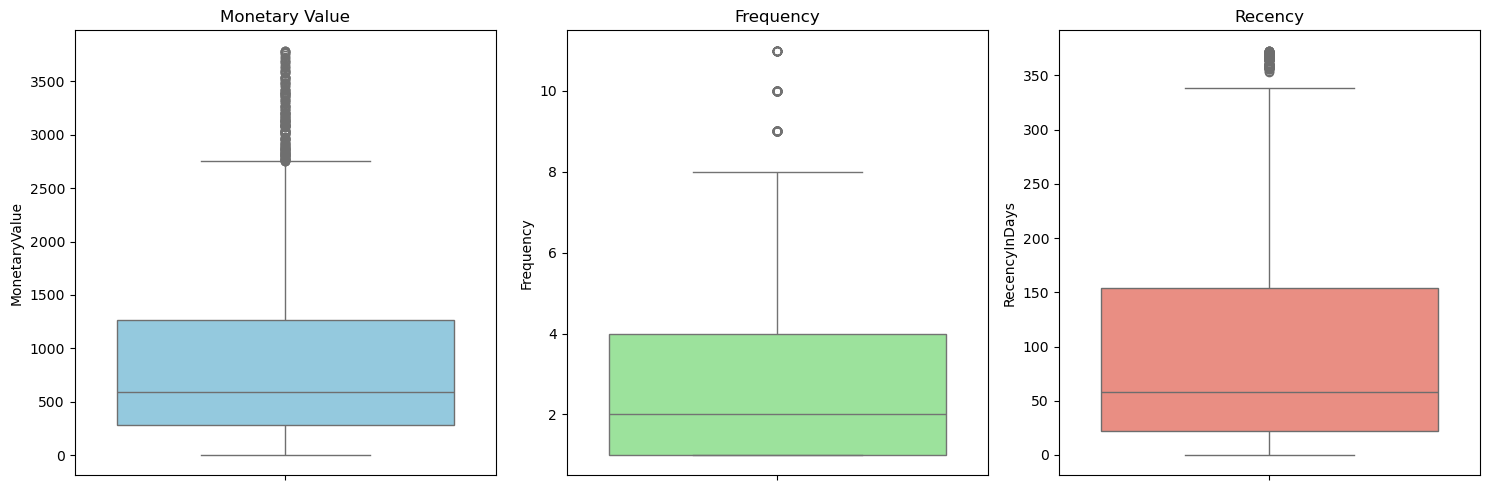

In [202]:
# Plot the boxplot of the non-outliers dataframe
plt.figure(figsize=(15, 5))

# Monetary Value
plt.subplot(1, 3, 1)
sns.boxplot(df_non_outliers['MonetaryValue'], color='skyblue')
plt.title('Monetary Value')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(df_non_outliers['Frequency'], color='lightgreen')
plt.title('Frequency')

# Recency
plt.subplot(1, 3, 3)
sns.boxplot(df_non_outliers['RecencyInDays'], color='salmon')
plt.title('Recency')

plt.tight_layout()
plt.show()

These plots now (without outliers) show a more normal distribution, and is much easier to read.

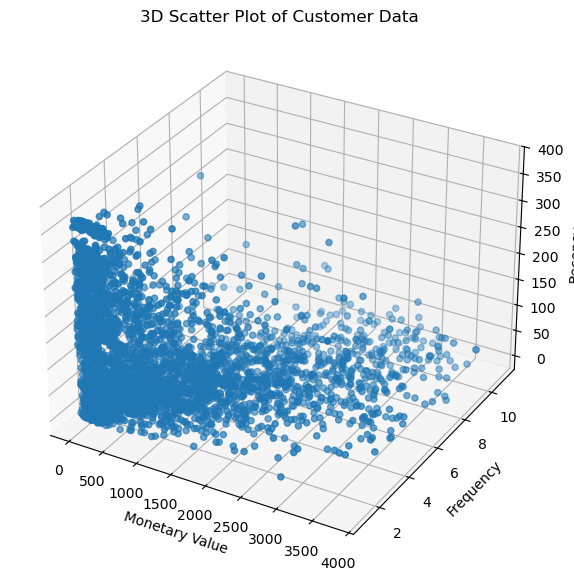

In [203]:
# 3d plot of the non-outliers dataframe
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_non_outliers['MonetaryValue'], df_non_outliers['Frequency'], df_non_outliers['RecencyInDays'])
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data')
plt.show()

We need to scale the data to ensure that the clustering algorithm does not favor certain features.

In [204]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_non_outliers[['Frequency', 'RecencyInDays', 'MonetaryValue']])

# View the first 5 rows of the scaled dataframe
df_scaled_data = pd.DataFrame(scaled_data, columns=['Frequency', 'RecencyInDays', 'MonetaryValue'])
df_scaled_data.head()

,Frequency,RecencyInDays,MonetaryValue
0,-0.385,0.682,-0.876
1,-0.385,-0.969,0.536
2,-0.831,-0.245,-0.813
3,-0.385,-0.561,1.634
4,-0.831,-0.888,-0.715


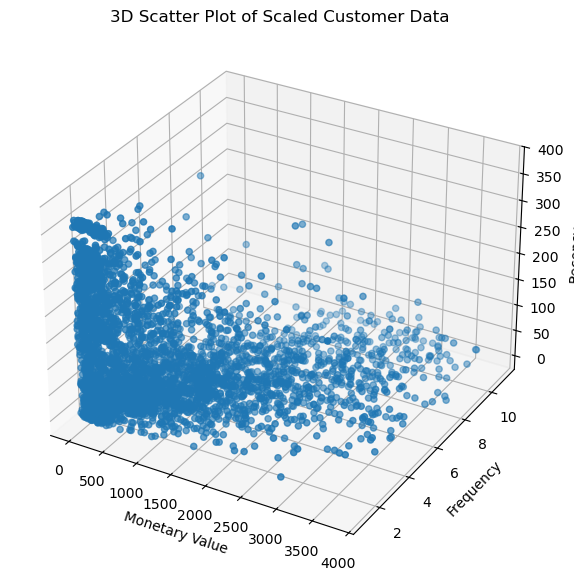

In [205]:
# 3D plot of the scaled data to validate the shape of the data has not changed
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_non_outliers['MonetaryValue'], df_non_outliers['Frequency'], df_non_outliers['RecencyInDays'])
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Scaled Customer Data')
plt.show()

## KMeans Clustering

In [206]:
# Set a max k of 12
max_k = 12

# Initialize a list to store the inertia values and silhouette scores
inertia = []
silhouette_scores = []

# Iterate through k values from 2 to max_k
k_values = range(2, max_k + 1)

# Fit the KMeans model for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(df_scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled_data, cluster_labels))

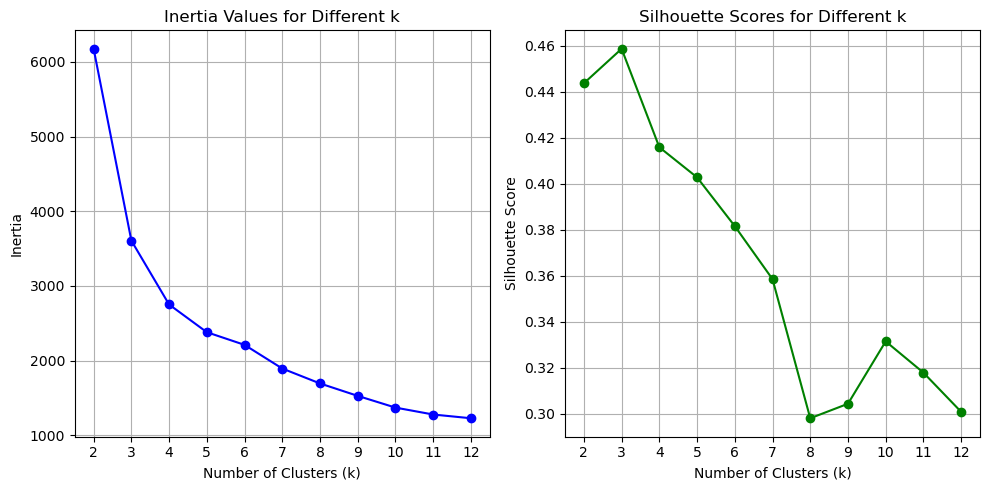

In [207]:
# Plot the inertia values and silhouette scores
plt.figure(figsize=(10, 5))

# Inertia
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Values for Different k')
plt.xticks(k_values)
plt.grid(True)

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

Looking at the inertia values as well as silhouette scores, it seems that 4 clusters is the optimal number of clusters.

In [208]:
# Use KMeans to cluster the data with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

# Fit the model
cluster_labels = kmeans.fit_predict(df_scaled_data)

# Add the cluster labels to the original dataframe
df_non_outliers['Cluster'] = cluster_labels

# View the first 5 rows of the dataframe
df_non_outliers.head()

/var/folders/_p/cdldnvm52d95tj5d950y42lr0000gn/T/ipykernel_72728/2851895501.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_outliers['Cluster'] = cluster_labels


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyInDays,Cluster
0,12346.000,169.360,2,2010-06-28 13:53:00,164,1
1,12347.000,1323.320,2,2010-12-07 14:57:00,2,0
2,12348.000,221.160,1,2010-09-27 14:59:00,73,2
3,12349.000,2221.140,2,2010-10-28 08:23:00,42,0
4,12351.000,300.930,1,2010-11-29 15:23:00,10,2


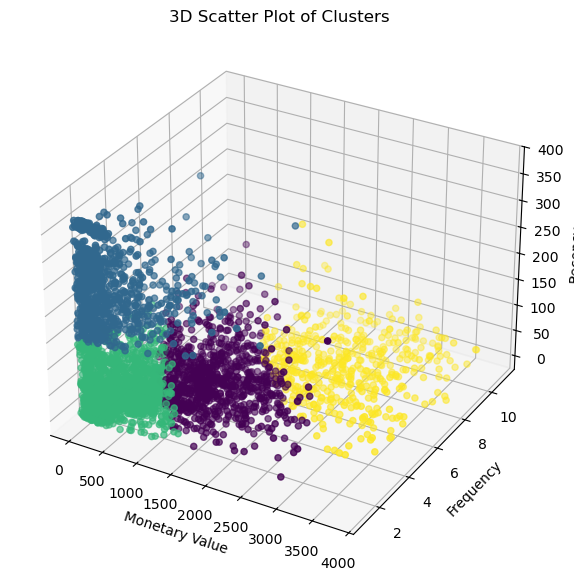

In [209]:
# 3d Plot of the clusters with colours for each cluster
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_non_outliers['MonetaryValue'], df_non_outliers['Frequency'], df_non_outliers['RecencyInDays'], c=df_non_outliers['Cluster'], cmap='viridis')
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Clusters')
plt.show()

### Outlier Analysis Visualization

The violin plots below show the distribution of our three key metrics across different outlier clusters:
- Monetary Value: Total customer spending
- Frequency: Number of purchases
- Recency: Days since last purchase

The width of each violin indicates the density of data points at that value.

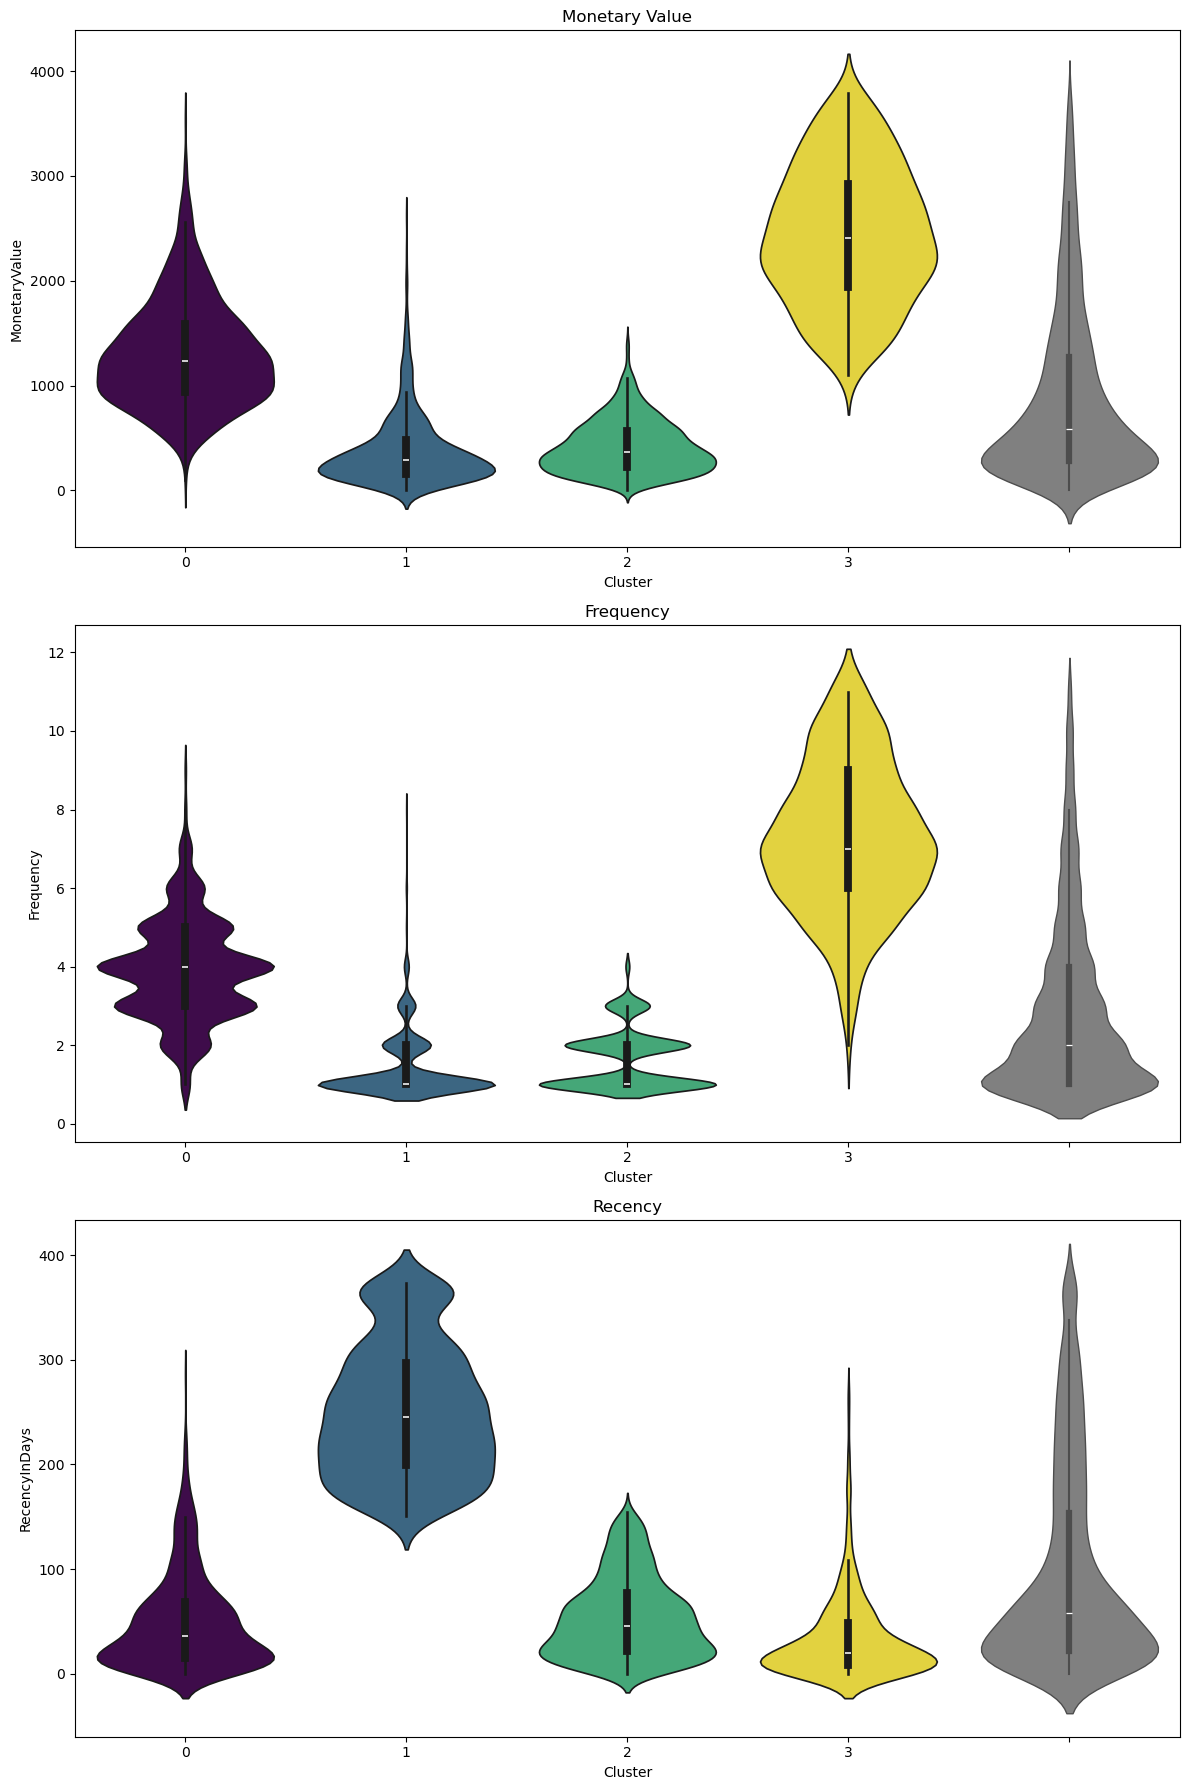

In [210]:
# Create violin plots of the clusters
plt.figure(figsize=(12, 18))

# Monetary Value
plt.subplot(3, 1, 1)
sns.violinplot(x='Cluster', y='MonetaryValue', data=df_non_outliers, palette='viridis', hue='Cluster', legend=False)
sns.violinplot(y='MonetaryValue', data=df_non_outliers, color='gray', linewidth=1.0)
plt.title('Monetary Value')

# Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=df_non_outliers, palette='viridis', hue='Cluster', legend=False)
sns.violinplot(y='Frequency', data=df_non_outliers, color='gray', linewidth=1.0)
plt.title('Frequency')

# Recency
plt.subplot(3, 1, 3)
sns.violinplot(x='Cluster', y='RecencyInDays', data=df_non_outliers, palette='viridis', hue='Cluster', legend=False)
sns.violinplot(y='RecencyInDays', data=df_non_outliers, color='gray', linewidth=1.0)
plt.title('Recency')

plt.tight_layout()
plt.show()

### Labeling the clusters

1. Cluster 0 (Zero) "Retain"
    - Rationale: Represents high-value customers who purchase frequently, though not always very recently. The focus should be on retention efforts to maintain their loyalty and spending levels.
    - Action: Implement a loyalty program to reward their frequent purchases and offer exclusive discounts or rewards.

2. Cluster 1 (One) "Re-Engage"
    - Rationale: Represents customers who purchase infrequently and have a low monetary value. The focus should be on re-engagement to bring them back into active purchasing.
    - Action: Use targeted marketing campaigns, personalised emails and special offers to re-engage these customers.

3. Cluster 2 (Two) "Nurture"
    - Rationale: Represents the least active and lowest value customers, but they have made recent purchases. These may be new customers or need nurturting to increase their engagement.
    - Action: Focus on building relationships, providing excellent customer service and offering incentives to encourage repeat purchases.

4. Cluster 3 (Three) "Reward"
    - Rationale: This cluster includes high-value, very frequent purchasers, many of whom have made recent purchases. They are the most valuable customers and should be rewarded to encourage continued loyalty.
    - Action: Implement a robust loyalty program with tiered rewards, special privileges and events to keep them engaged and spending.

### Dealing with the outliers from earlier

In [211]:
# Find the overlap between monetary and frequency outliers
overlap_indices = df_monetary_outliers.index.intersection(df_frequency_outliers.index)

# Only monetary outliers
df_monetary_outliers_only = df_monetary_outliers.drop(index=overlap_indices)

# Only frequency outliers
df_frequency_outliers_only = df_frequency_outliers.drop(index=overlap_indices)

# Both monetary and frequency outliers
df_both_outliers = df_monetary_outliers.loc[overlap_indices]

# Assigning the outliers to a new cluster
df_both_outliers['Cluster'] = -3
df_frequency_outliers_only['Cluster'] = -2
df_monetary_outliers_only['Cluster'] = -1

# Concatenate the dataframes
df_outliers_clusters = pd.concat([df_both_outliers, df_monetary_outliers_only, df_frequency_outliers_only])

# View the first 5 rows of the dataframe
df_outliers_clusters.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyInDays,Cluster
65,12437.000,6834.990,20,2010-11-09 14:46:00,30,-3
84,12471.000,17721.450,44,2010-11-30 14:35:00,9,-3
85,12472.000,10426.480,13,2010-12-05 14:19:00,4,-3
92,12482.000,21941.720,27,2010-05-12 16:51:00,211,-3
126,12540.000,7670.250,15,2010-11-26 10:43:00,13,-3


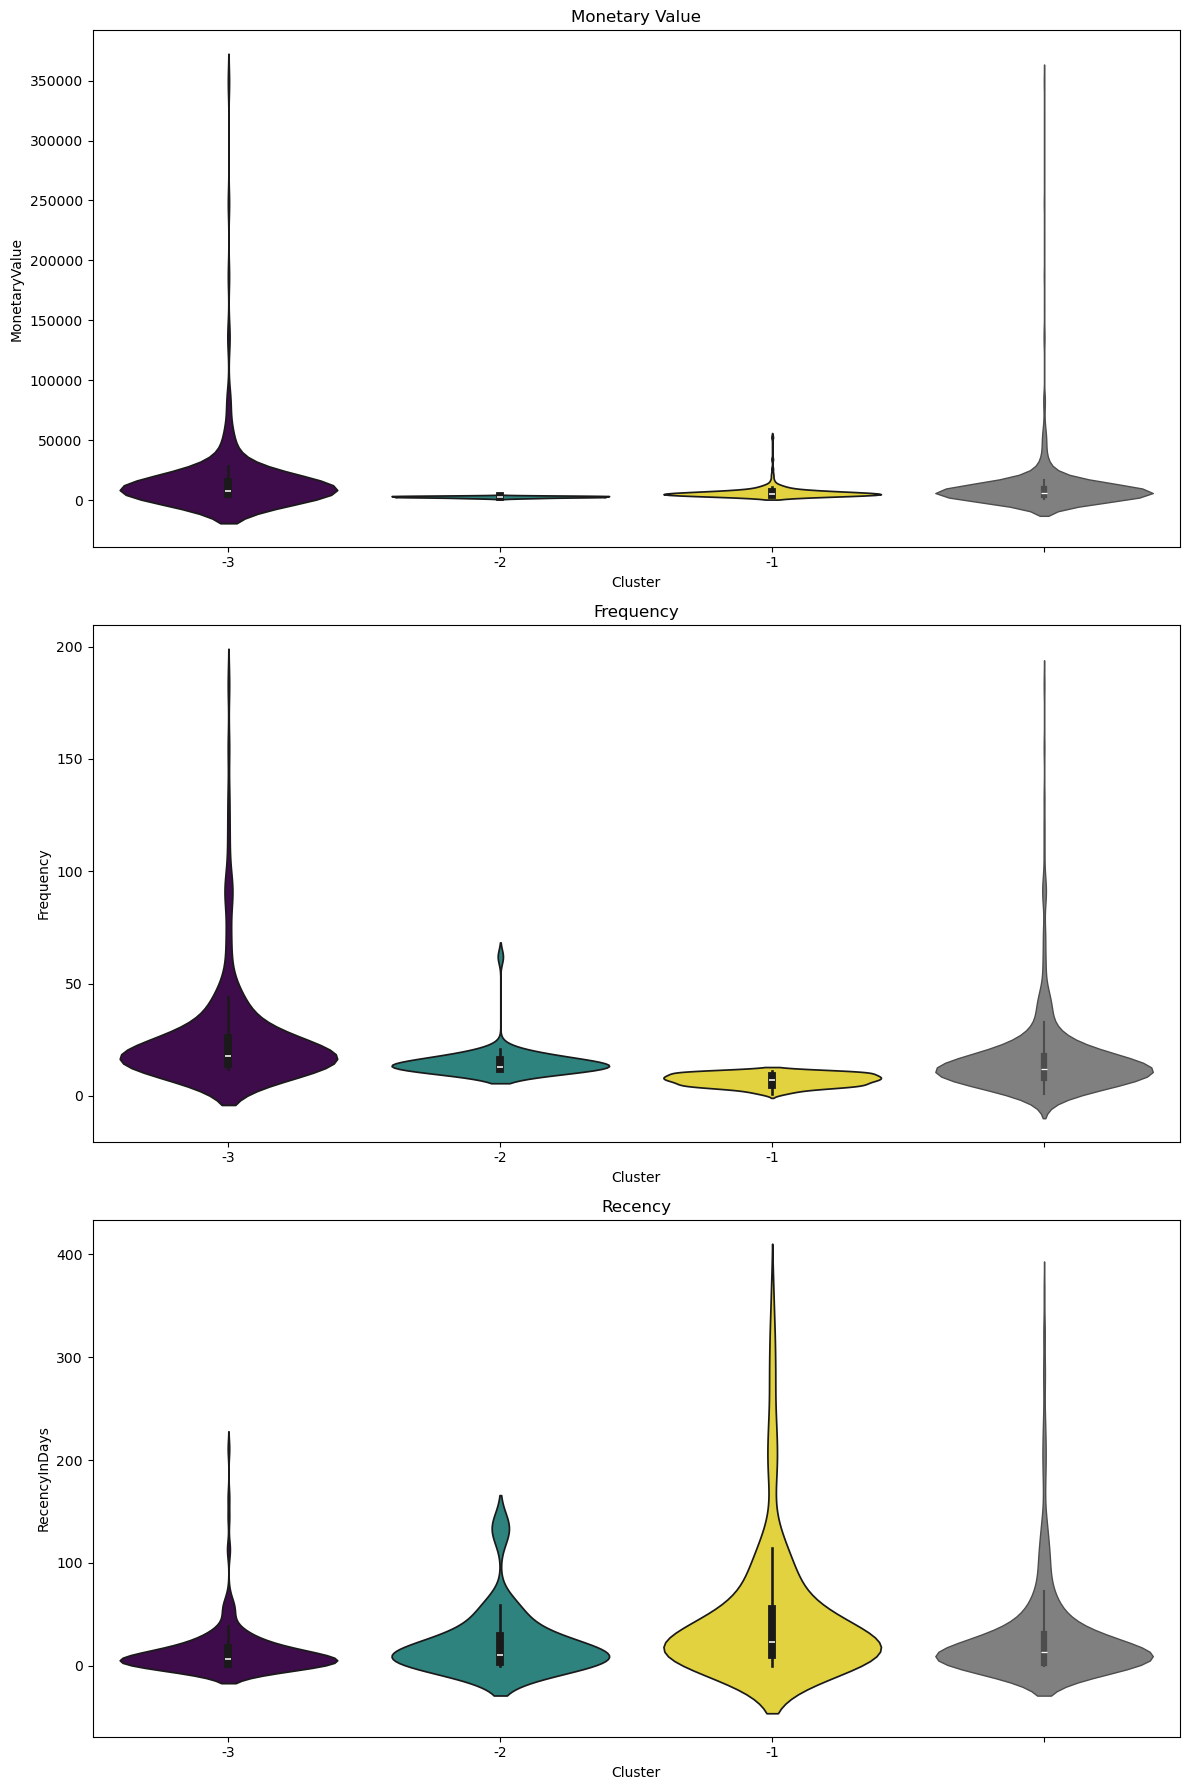

In [212]:
# Create violin plots of the outliers clusters
plt.figure(figsize=(12, 18))

# Monetary Value
plt.subplot(3, 1, 1)
sns.violinplot(x='Cluster', y='MonetaryValue', data=df_outliers_clusters, palette='viridis', hue='Cluster', legend=False)
sns.violinplot(y='MonetaryValue', data=df_outliers_clusters, color='gray', linewidth=1.0)
plt.title('Monetary Value')

# Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=df_outliers_clusters, palette='viridis', hue='Cluster', legend=False)
sns.violinplot(y='Frequency', data=df_outliers_clusters, color='gray', linewidth=1.0)
plt.title('Frequency')

# Recency
plt.subplot(3, 1, 3)
sns.violinplot(x='Cluster', y='RecencyInDays', data=df_outliers_clusters, palette='viridis', hue='Cluster', legend=False)
sns.violinplot(y='RecencyInDays', data=df_outliers_clusters, color='gray', linewidth=1.0)
plt.title('Recency')

plt.tight_layout()
plt.show()

### Labeling the clusters

1. Cluster -1 (Negative One) (Monetary Outliers Only)
    - Characteristics: High spenders but not necessarily frequent purchasers. Their purchases are large in value but infrequent.
    - Action: Focus on retention efforts to maintain their loyalty and spending levels.

2. Cluster -2 (Negative Two) (Frequency Outliers Only)
    - Characteristics: Frequent purchasers who spend low amounts. These customers are consistently engaged but might benefit from upselling opportunities.
    - Action: Implement loyalty programs to reward their frequent purchases and offer exclusive discounts or rewards to encourage higher spending per visit.

3. Cluster -3 (Negative Three) (Both Outliers)
    - Characteristics: The most valuable outliers, with extreme spending and frequent purchases. They are likely your top-tier customers who require special attention.
    - Action: Develop a VIP program with exclusive offers, personalised experiences and dedicated support to keep them engaged and spending.

In [213]:
cluster_labels = {
    -3: 'DELIGHT',
    -2: 'UPSELL',
    -1: 'PAMPER',
    0: 'RETAIN',
    1: 'RE-ENGAGE',
    2: 'NURTURE',
    3: 'REWARD'
}

# Concatenate the dataframes
df_full_clustering = pd.concat([df_non_outliers, df_outliers_clusters])

# Add the cluster labels to the original dataframe
df_full_clustering['ClusterLabel'] = df_full_clustering['Cluster'].map(cluster_labels)

# View the first 5 rows of the dataframe
df_full_clustering.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyInDays,Cluster,ClusterLabel
0,12346.000,169.360,2,2010-06-28 13:53:00,164,1,RE-ENGAGE
1,12347.000,1323.320,2,2010-12-07 14:57:00,2,0,RETAIN
2,12348.000,221.160,1,2010-09-27 14:59:00,73,2,NURTURE
3,12349.000,2221.140,2,2010-10-28 08:23:00,42,0,RETAIN
4,12351.000,300.930,1,2010-11-29 15:23:00,10,2,NURTURE


### Final Customer Segments

We've identified 7 distinct customer segments:
- DELIGHT (-3): High-value, frequent customers
- UPSELL (-2): Frequent buyers with lower spending
- PAMPER (-1): Big spenders with low frequency
- RETAIN (0): Valuable regular customers
- RE-ENGAGE (1): Formerly active customers
- NURTURE (2): New or low-value customers
- REWARD (3): Active mid-tier customers

Each segment requires different marketing and retention strategies.

## Visualisation

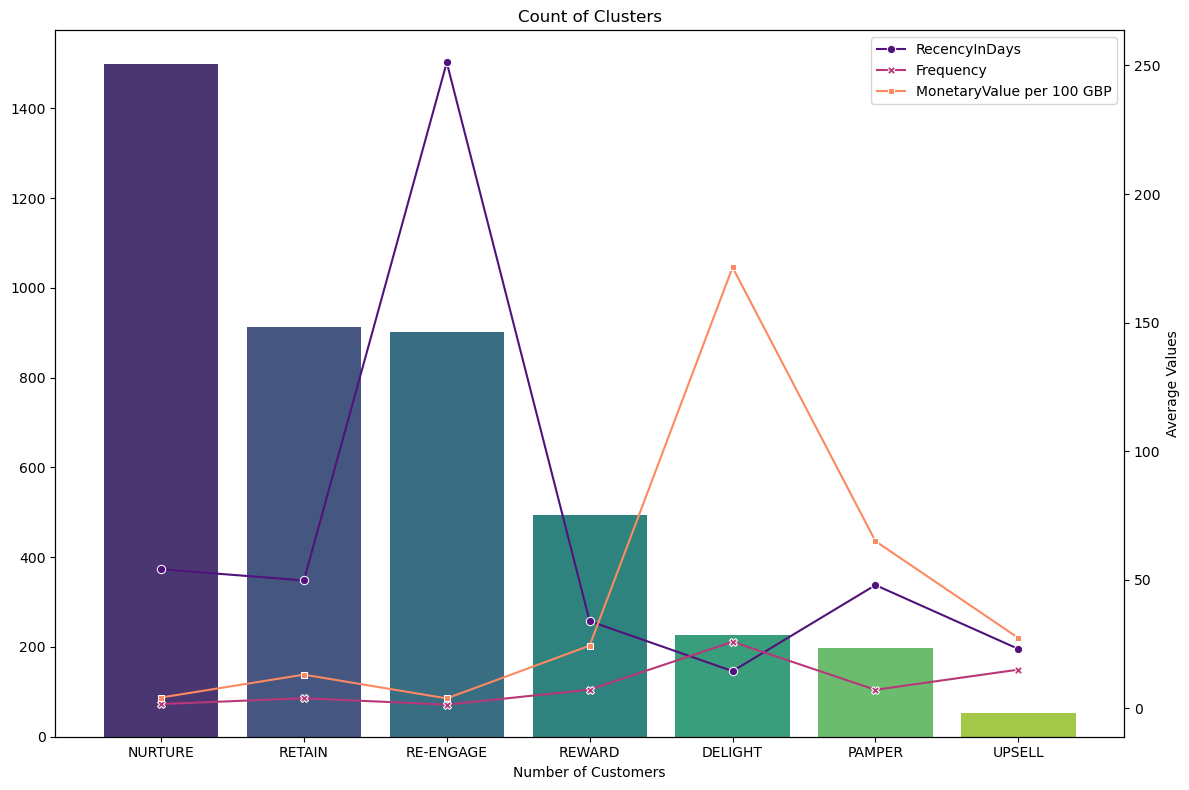

In [214]:
# Count of clusters
cluster_counts = df_full_clustering['ClusterLabel'].value_counts()

# Add a new column to scale the monetary value
df_full_clustering['MonetaryValue per 100 GBP'] = df_full_clustering['MonetaryValue'] / 100

# Mean of clusters by feature
feature_means = df_full_clustering.groupby(by='ClusterLabel')[['RecencyInDays', 'Frequency', 'MonetaryValue per 100 GBP']].mean()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot barplot of cluster counts
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_title('Count of Clusters')
ax1.set_xlabel('Number of Customers')

# Plot mean of features by cluster
ax2 = ax1.twinx()
sns.lineplot(data=feature_means, ax=ax2, palette='magma', markers=True, dashes=False)
ax2.set_ylabel('Average Values')

plt.tight_layout()
plt.show()

### Segment Distribution and Characteristics

The visualization shows:
- Bar chart: Number of customers in each segment
- Line plots: Average values for RFM metrics by segment

This helps us understand both the size and characteristics of each customer segment.